In [2]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.0 MB/s eta 0:00:00


In [45]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random

class TemperatureControlEnv(gym.Env):
    def __init__(self):
        super(TemperatureControlEnv, self).__init__()

        self.action_space = spaces.Discrete(2)  # 0, 1
        self.observation_space = spaces.Box(low=15.0, high=30.0, shape=(1,), dtype=np.float32)

        self.state = None
        self.target_temp = 22.5
        self.threshold = 0.5
        self.steps = 0
        self.max_steps = 100

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = random.uniform(15.0, 30.0)
        self.steps = 0
        return np.array([self.state]), {}

    def step(self, action):
        self.steps += 1
        if action == 0:
          self.state += -0.25 # move left
        if action == 1:
          self.state += 0.25 # move right
        #+ self.np_random.normal(0, 0.1, size=(1,))
        self.state = np.clip(self.state, self.observation_space.low, self.observation_space.high).astype(np.float32)

        temp_diff = np.abs(self.state - self.target_temp).item()
        if temp_diff <= self.threshold:
            reward = 0
        else:
            reward = -1
        terminated = temp_diff <= self.threshold
        truncated = self.steps >= self.max_steps

        return self.state, reward, terminated, truncated, {}

    def render(self):
        print(f"Current temperature: {self.state[0]:.2f}°C, Target: {self.target_temp:.2f}°C, Steps: {self.steps}")

gym.register(
    id='TemperatureControl-v0',
    entry_point='__main__:TemperatureControlEnv',
    max_episode_steps=100,
)

In [46]:
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

def set_seed(seed):
    #print(f"Setting random seed: {seed}")
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class Policy(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        #print(f"Initializing Policy with {num_features} features")
        self.theta = nn.Parameter(torch.rand(num_features), requires_grad=True)

    def forward(self, features):
        #print("Policy forward pass")
        logits = torch.einsum('ijk,k->ij', features, self.theta)
        return F.softmax(logits, dim=-1)

class RandomNNFeatures(nn.Module):
    def __init__(self, input_dim, num_features, sigma=1.0, kernel_type='gaussian1', seed=42):
        super().__init__()
        #print(f"Initializing RandomNNFeatures: input_dim={input_dim}, num_features={num_features}, kernel_type={kernel_type}")
        self.input_dim = input_dim
        self.num_features = num_features
        self.sigma = sigma
        self.kernel_type = kernel_type

        set_seed(seed)

        if kernel_type == 'gaussian1':
            self.linear = nn.Linear(input_dim, num_features, bias=True)
            nn.init.normal_(self.linear.weight, std=torch.sqrt(torch.tensor(1.0 / sigma)))
            nn.init.uniform_(self.linear.bias, 0, 2 * torch.pi)
        elif kernel_type == 'gaussian2':
            self.linear = nn.Linear(input_dim, num_features // 2, bias=False)
            nn.init.normal_(self.linear.weight, std=torch.sqrt(torch.tensor(1.0 / sigma)))
        elif kernel_type == 'cauchy1':
            self.W = nn.Parameter(torch.cauchy(torch.zeros(input_dim, num_features), sigma), requires_grad=False)
            self.b = nn.Parameter(torch.rand(num_features) * 2 * torch.pi, requires_grad=False)
        elif kernel_type == 'cauchy2':
            self.W = nn.Parameter(torch.cauchy(torch.zeros(input_dim, num_features // 2), sigma), requires_grad=False)
        elif kernel_type == 'laplace1':
            self.W = nn.Parameter(torch.laplace(torch.zeros(input_dim, num_features), sigma), requires_grad=False)
            self.b = nn.Parameter(torch.rand(num_features) * 2 * torch.pi, requires_grad=False)
        elif kernel_type == 'laplace2':
            self.W = nn.Parameter(torch.laplace(torch.zeros(input_dim, num_features // 2), sigma), requires_grad=False)
        else:
            raise ValueError(f"Unsupported kernel type: {kernel_type}")

    def forward(self, x):
        #print("RandomNNFeatures forward pass")
        if self.kernel_type == 'gaussian1':
            return torch.sqrt(torch.tensor(2.0 / self.num_features)) * torch.cos(self.linear(x))
        elif self.kernel_type == 'gaussian2':
            projection = self.linear(x)
            features = torch.cat([torch.cos(projection), torch.sin(projection)], dim=-1)
            return torch.sqrt(torch.tensor(2.0 / self.num_features)) * features
        elif self.kernel_type == 'cauchy1':
            return torch.sqrt(torch.tensor(2.0 / self.num_features)) * torch.cos(x @ self.W + self.b)
        elif self.kernel_type == 'cauchy2':
            projection = x @ self.W
            features = torch.cat([torch.cos(projection), torch.sin(projection)], dim=-1)
            return torch.sqrt(torch.tensor(2.0 / self.num_features)) * features
        elif self.kernel_type == 'laplace1':
            return torch.sqrt(torch.tensor(2.0 / self.num_features)) * torch.cos(x @ self.W + self.b)
        elif self.kernel_type == 'laplace2':
            projection = x @ self.W
            features = torch.cat([torch.cos(projection), torch.sin(projection)], dim=-1)
            return torch.sqrt(torch.tensor(2.0 / self.num_features)) * features
        else:
            raise ValueError(f"Unsupported kernel type: {self.kernel_type}")

class DataCollector:
    def __init__(self, env_name='TemperatureControl-v0', kernel_type='gaussian1', num_features=8, seed=42, sigma=1.0):
        #print(f"Initializing DataCollector: env_name={env_name}, kernel_type={kernel_type}, num_features={num_features}")
        self.env = gym.make(env_name)
        self.num_features = num_features
        self.num_actions = self.env.action_space.n
        self.sigma = sigma

        torch.manual_seed(seed)
        np.random.seed(seed)

        self.rnf = RandomNNFeatures(input_dim=3, num_features=num_features, kernel_type='gaussian1', seed=seed)
        self.policy = Policy(num_features)

    def get_features(self, state, action=None):
        #print("Getting features")
        if state.dim() == 1:
            state = state.unsqueeze(0)

        if action is None:
            features = []
            #print(state.shape)
            for a in range(self.num_actions):
                one_hot = F.one_hot(torch.tensor(a), num_classes=self.num_actions).float().expand(state.shape[0], -1)
                features.append(self.rnf(torch.cat([state, one_hot], dim=-1)))
            features = torch.stack(features, dim=1)
        else:
            if isinstance(action, int):
                action = torch.tensor([action])
            one_hot = F.one_hot(action, num_classes=self.num_actions).float()
            if one_hot.dim() == 1:
                one_hot = one_hot.unsqueeze(0)
            features = self.rnf(torch.cat([state, one_hot], dim=-1))

        return features

    def generate_optimal_actions(self, states):
        #print("Generating optimal actions")
        if not isinstance(states, torch.Tensor):
            states = torch.tensor(states, dtype=torch.float32)

        states_flat = states.reshape(-1)
        optimal_actions = torch.zeros_like(states_flat, dtype=torch.long)
        optimal_actions[states_flat < (self.env.target_temp - self.env.threshold)] = 1
        optimal_actions = optimal_actions.reshape(states.shape)

        return optimal_actions

    def sample_action(self, state):
        #print("Sampling action")
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        features = self.get_features(state_tensor)
        probs = self.policy(features).squeeze(0)
        action = torch.multinomial(probs, num_samples=1).item()
        return action

    def collect_dataset(self, num_timesteps):
        #print(f"Collecting dataset: num_timesteps={num_timesteps}")
        states, actions, rewards, next_states, initial_states, dones = [], [], [], [], [], []
        total_steps = 0

        while total_steps < num_timesteps:
            state, _ = self.env.reset()
            initial_states.append(state)

            while True:
                action = self.sample_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                next_states.append(next_state)
                dones.append(done)

                state = next_state
                total_steps += 1

                if done or total_steps >= num_timesteps:
                    break

        initial_states = torch.tensor(np.array(initial_states), dtype=torch.float32)
        states = torch.tensor(np.array(states), dtype=torch.float32)
        filtered_indices = torch.where((states < 22) | (states > 23))

        filtered_states = states[filtered_indices]
        actions = torch.tensor(actions, dtype=torch.long)
        optimal_actions = self.generate_optimal_actions(filtered_states)

        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.bool)

        X = torch.stack([self.get_features(s.unsqueeze(0), a).squeeze(0) for s, a in zip(states, actions)])
        X_opt = torch.stack([self.get_features(s.unsqueeze(0), a).squeeze(0) for s, a in zip(states, optimal_actions)])

        return initial_states, states, actions, rewards, next_states, dones, X, X_opt

class PolicyOptimizer:
    def __init__(self, collector, env_name='TemperatureControl-v0', kernel_type='gaussian1', num_features=8, sigma=0.1, learning_rate=0.01, gamma=0.99, regularizer=0.001, seed=42):
        #print(f"Initializing PolicyOptimizer: env_name={env_name}, kernel_type={kernel_type}, num_features={num_features}")
        self.env = gym.make(env_name)
        self.collector = collector
        self.policy = self.collector.policy
        self.rnf = self.collector.rnf
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.regularizer = regularizer
        self.env = gym.make(env_name)

    def compute_Y(self, next_states):
        #print("Computing Y")
        features = self.collector.get_features(next_states)
        probs = self.policy(features)
        Y = torch.einsum('ijk,ij->ik', features, probs)
        return Y

    def compute_W(self, initial_states):
        #print("Computing W")
        features = self.collector.get_features(initial_states)
        probs = self.policy(features)
        W = torch.einsum('ijk,ij->k', features, probs)
        W = W / initial_states.shape[0]
        return W

    def compute_J(self, X, next_states, initial_states, rewards):
        #print("Computing J")
        latent_dim = X.shape[1]
        C_lambda = X.T @ X + self.regularizer * torch.eye(latent_dim)

        #print("Computing Y...")
        #print(next_states.shape)
        features = self.collector.get_features(next_states)
        #print(features.shape)
        probs = self.policy(features)
        Y = torch.einsum('ijk,ij->ik', features, probs)

        features = self.collector.get_features(initial_states)
        probs = self.policy(features)
        W = torch.einsum('ijk,ij->k', features, probs)
        W = W / initial_states.shape[0]

        D = X.T @ Y
        E = X.T @ rewards

        A = torch.linalg.solve(C_lambda, E).T
        M = torch.linalg.solve(C_lambda, D).T

        J = A @ torch.linalg.solve(torch.eye(latent_dim) - self.gamma * M, torch.eye(latent_dim)) @ W
        return J

    def evaluate_policy(self, num_episodes=100):
        #print(f"Evaluating policy: num_episodes={num_episodes}")
        total_reward = []
        for _ in range(num_episodes):
            state, _ = self.env.reset()
            done = False
            episode_reward = 0
            while not done:
                action = self.collector.sample_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                episode_reward += reward
                state = next_state
            total_reward.append(episode_reward)
        return np.mean(total_reward)

    def optimize(self, num_epochs, num_timesteps=10000):
        #print(f"Optimizing policy: num_epochs={num_epochs}, num_timesteps={num_timesteps}")
        initial_states, states, actions, rewards, next_states, dones, X, X_opt = self.collector.collect_dataset(num_timesteps)
        #print("Data collection is complete...")
        optimal_theta = torch.linalg.solve(X_opt.T @ X_opt, X_opt.T @ torch.ones(X_opt.shape[0]))
        #print(f"Optimal theta: {optimal_theta}")

        history = []
        J_history = []
        optimizer = optim.Adam(self.policy.parameters(), lr=self.learning_rate)
        #print(f"Theta: {self.policy.theta}")

        X = X.detach()
        next_states = next_states.detach()
        initial_states = initial_states.detach()
        rewards = rewards.detach()

        #print("Begin policy optimization...")
        for epoch in tqdm(range(num_epochs)):
            optimizer.zero_grad()
            #print(next_states.shape)
            J = self.compute_J(X, next_states, initial_states, rewards)
            J_history.append(J.item())

            loss = J

            loss.backward()
            optimizer.step()

            if (epoch + 1) % 5 == 0:
                with torch.no_grad():
                    avg_reward = self.evaluate_policy()
                history.append(avg_reward)
                #print(f"Epoch {epoch + 1}/{num_epochs}, Average Reward: {avg_reward:.4f}")
                #print(f"Theta: {self.policy.theta}")

        with torch.no_grad():
            final_avg_reward = self.evaluate_policy()
        history.append(final_avg_reward)

        return history, optimal_theta, J_history

def evaluate_policy(env_name, collector, num_episodes=100):
    #print(f"Evaluating policy: env_name={env_name}, num_episodes={num_episodes}")
    env = gym.make(env_name)
    total_rewards = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        while not done:
            features = collector.get_features(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
            probs = collector.policy(features).squeeze(0)
            action = torch.argmax(probs).item()
            state, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            done = terminated or truncated
        total_rewards.append(episode_reward)
    return np.mean(total_rewards)


env_name= 'TemperatureControl-v0'

def run_experiment(env_name, kernel_type, num_features, num_epochs, sigma, learning_rate, gamma, regularizer, num_timesteps):
    #print("Initialising Data Collector")
    collector = DataCollector(env_name, kernel_type=kernel_type, num_features=num_features)
    #initial_states, states, actions, rewards, next_states, dones, X, X_opt, Y, W = collector.collect_dataset(num_timesteps)

    # Run optimization
    optimizer = PolicyOptimizer(collector, env_name, kernel_type=kernel_type, num_features=num_features, sigma=sigma, learning_rate=learning_rate, gamma=gamma, regularizer=regularizer)
    history, optimal_theta, J_history = optimizer.optimize(num_epochs, num_timesteps)

    collector.policy.theta.data = optimal_theta
    optimal_reward = evaluate_policy(env_name, collector)
    #print(f"Optimal theta: {optimal_theta}")

    return history, optimal_reward, J_history

# Run experiments
num_epochs = 100
num_timesteps = 10000

#gaussian1_history, gaussian1_optimal, J_history1 = run_experiment(env_name, kernel_type='gaussian1', num_features=30, num_epochs=num_epochs, sigma=0.1, learning_rate=0.01, gamma=0.99, regularizer=0.001, num_timesteps=num_timesteps)
gaussian_history, gaussian_optimal, J_history = run_experiment(env_name, kernel_type='gaussian2', num_features=30, num_epochs=num_epochs, sigma=0.1, learning_rate=0.01, gamma=0.99, regularizer=0.001, num_timesteps=num_timesteps)

# Plotting
plt.figure(figsize=(10, 6))

# Plot Gaussian 1
#plt.plot(range(0, num_epochs, 100), J_history1, 'purple', label='J forGaussian 1')
#plt.axhline(y=gaussian1_optimal, color='purple', linestyle='--', label='SL solution (Gaussian 1)')

# Plot Gaussian 2
#plt.plot(range(0, num_epochs, 100), J_history2, 'red', label='J for Gaussian 2')
#plt.axhline(y=gaussian2_optimal, color='red', linestyle='--', label='SL solution (Gaussian 2)')

#plt.xlabel('Num of epochs')
#plt.ylabel('Average Reward')
#plt.title('RL Algorithm Performance Comparison')
#plt.legend()
#plt.grid(True)

#plt.show()

100%|██████████| 100/100 [00:28<00:00,  3.47it/s]


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

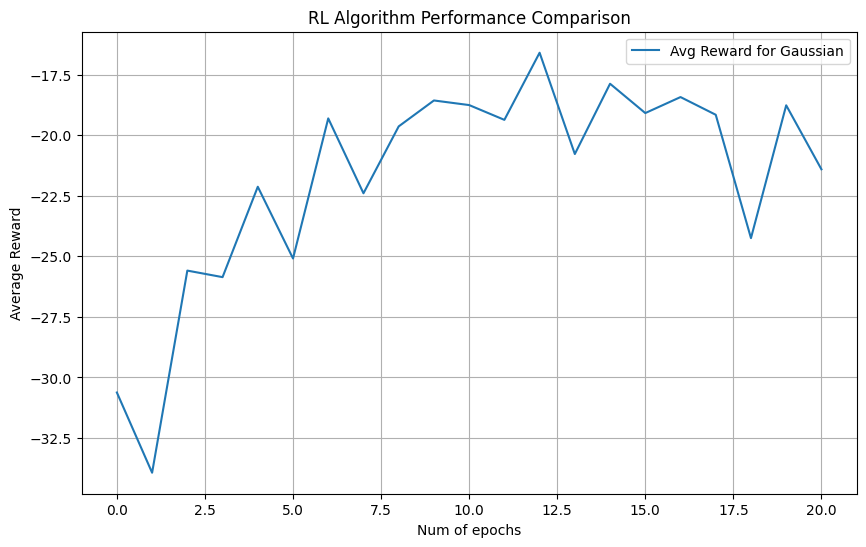

In [47]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot Gaussian 2
plt.plot(gaussian_history[:100], label='Avg Reward for Gaussian')
#plt.axhline(y=gaussian2_optimal, color='red', linestyle='--', label='SL solution (Gaussian 2)')

plt.xlabel('Num of epochs')
plt.ylabel('Average Reward')
plt.title('RL Algorithm Performance Comparison')
plt.legend()
plt.grid(True)

plt.show()

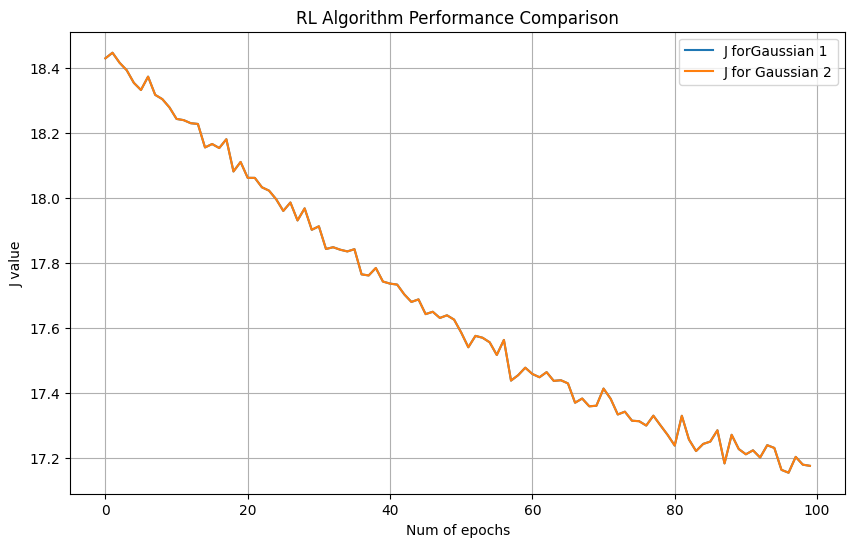

In [44]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot Gaussian 1
plt.plot(J_history[:100], label='J forGaussian 1')
#plt.axhline(y=gaussian1_optimal, color='purple', linestyle='--', label='SL solution (Gaussian 1)')

# Plot Gaussian 2
plt.plot(J_history[:100], label='J for Gaussian 2')
#plt.axhline(y=gaussian2_optimal, color='red', linestyle='--', label='SL solution (Gaussian 2)')

plt.xlabel('Num of epochs')
plt.ylabel('J value')
plt.title('RL Algorithm Performance Comparison')
plt.legend()
plt.grid(True)

plt.show()

In [20]:
max(J_history1)

36063.21875